# Antonio Esteves

* Realize uma an√°lise explorat√≥ria nos dados, identificando e explorando (10 pts.): 
  * **(i)** correla√ß√µes entre as vari√°veis - **DONE** 
  * **(ii)** distribui√ß√£o das vari√°veis - **DONE** 
  * **(iii)** valores ausentes - **DONE** 
* Usando todas as vari√°veis dispon√≠veis, tune (usando valida√ß√£o cruzada): 
  * **(i)** um modelo de regress√£o Ridge - **DONE** 
  * **(ii)** um modelo de regress√£o Lasso - **DONE** 
  * **(iii)** um modelo KNN - **DONE** 
  
  Para os modelos de regress√£o linear, o par√¢metro a ser tunado √© o lambda (penaliza√ß√£o dos coeficientes) e no KNN o n√∫mero (K) de vizinhos. Compare os tr√™s modelos em termos do erro RMSE de valida√ß√£o cruzada. (30 pts.)  - **DONE** 

* Quais as vari√°veis mais importantes segundo o modelo de regress√£o Ridge e Lasso?  Vari√°veis foram descartadas pelo Lasso? Quais? (10 pts.)

* Re-treine o melhor modelo (usando os melhores valores de par√¢metros encontrados em todos os dados, sem usar valida√ß√£o cruzada). Use esse √∫ltimo modelo treinado para prever os dados de teste dispon√≠veis no challenge que criamos na plataforma Kaggle (30 pts.)

### Ideias para melhorar os resultados:

* Tente criar novas vari√°veis a partir das vari√°veis existentes. 
* Tente usar transforma√ß√µes (e.g. log) nas vari√°veis que apresentarem vi√©s.
* Tente normalizar as vari√°veis.
* Experimente estrat√©gias diferentes para lidar com dados ausentes (NAs).
* Use outros m√©todos de regress√£o. Por exemplo, SVR, √Årvores de Regress√£o e Florestas Aleat√≥rias.

# Depend√™ncias

In [480]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Declarando Fun√ß√µes

In [481]:
def get_result(train_rmse, test_rmse):
    df = pd.DataFrame(columns=['RMSE Treino', 'RMSE Teste'], index = ['Ridge', 'Lasso', 'KNN', 'Decision Tree', 'Random Forest'])
    df['RMSE Treino'] = np.array(train_rmse)
    df['RMSE Teste'] = np.array(test_rmse)
    df = df.T
    
    return df

In [482]:
def predict_plot(y, y_pred, label_set, label_var, color):
    plt.figure(figsize=(15, 10))
    plt.title('Estimativa de predi√ß√£o sob os dados de ' + label_set + ' - '+ label_var, fontsize=20)
    plt.plot(y, label='Actual', color=color[0])
    plt.plot(y_pred, label='Predicted', color=color[1])
    plt.xlabel('n-√©sima amostra')
    plt.ylabel('CRA')
    plt.grid()
    plt.legend()

In [483]:
def scores_plot(df):
    df = df.T.head(25)
    df.plot(kind='bar',figsize=(15,10), color=['#669ACC', 'yellowgreen'])
    plt.title('Comparativo RMSE Treino vs Teste', fontsize=20)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='#D3D3D3')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.xticks(rotation='horizontal')
    plt.show()

In [484]:
def get_results(pipeline, parameters, X_train, y_train, X, y):

    grid_obj = GridSearchCV(estimator=pipeline,
                            param_grid=parameters,
                            cv=3,
                            scoring='r2',
                            verbose=2,
                            n_jobs=1,
                            refit=True)
    grid_obj.fit(X_train, y_train)

    '''Results'''

    results = pd.DataFrame(pd.DataFrame(grid_obj.cv_results_))
    results_sorted = results.sort_values(by=['mean_test_score'], ascending=False)

    return results_sorted, grid_obj

In [485]:
def model(pipeline, parameters, X_train, y_train, X, y):

    grid_obj = GridSearchCV(estimator=pipeline,
                            param_grid=parameters,
                            cv=3,
                            scoring='r2',
                            verbose=2,
                            n_jobs=1,
                            refit=True)
    grid_obj.fit(X_train, y_train)

    '''Results'''

    results = pd.DataFrame(pd.DataFrame(grid_obj.cv_results_))
    results_sorted = results.sort_values(by=['mean_test_score'], ascending=False)
    
    print()
    print("##### Results #####")
    print(results_sorted)
    
    print()
    print("best_index", grid_obj.best_index_)
    print("best_score", grid_obj.best_score_)
    print("best_params", grid_obj.best_params_)

    '''Cross Validation'''

    estimator = grid_obj.best_estimator_
    '''
    if estimator.named_steps['scl'] == True:
        X = (X - X.mean()) / (X.std())
        y = (y - y.mean()) / (y.std())
    '''
    shuffle = KFold(n_splits=5,
                    shuffle=True,
                    random_state=0)
    cv_scores = cross_val_score(estimator,
                                X,
                                y.values.ravel(),
                                cv=shuffle,
                                scoring='r2')
    
    print()
    print("##### CV Results #####")
    print("mean_score", cv_scores.mean())
    
    '''Show model coefficients or feature importances'''

    try:
        # print("Model coefficients: ", list(zip(list(X), estimator.named_steps['clf'].coef_)))
        print()
        print("##### Model coefficients: #####")

        names = X.columns
        for c, att in zip(estimator.named_steps['clf'].coef_, names):
            print(type(c))
            print('{}: {}'.format(att, round(c, 3)))
    except:
        print()
        print("Model does not support model coefficients")

    try:
        print()
        print("##### Feature importances: #####")
        print(list(zip(list(X), estimator.named_steps['clf'].feature_importances_)))
    except:
        print()
        print("Model does not support feature importances")
        
    '''Predict along CV and plot y vs. y_predicted in scatter'''

In [486]:
def features_coefficients(estimator):
    try:
    # print("Model coefficients: ", list(zip(list(X), estimator.named_steps['clf'].coef_)))
        print()
        print("##### Model coefficients: #####")

        names = X.columns
        for c, att in zip(estimator.named_steps['clf'].coef_, names):
            print('{}: {}'.format(att, round(c, 3)))
    except:
        print()
        print("Model does not support model coefficients")

    try:
        print()
        print("##### Feature importances: #####")
#         print(list(zip(list(X), estimator.named_steps['clf'].feature_importances_)))
        names = X.columns
        for c, att in zip(estimator.named_steps['clf'].feature_importances_, names):
            print('{}: {}'.format(att, round(c, 3)))
    except:
        print()
        print("Model does not support feature importances")

# Carregando Dados

In [626]:
train_rmse = []
test_rmse = []
cartola = pd.read_csv('../data/cartola_2014/cartola_2014_train.csv')
df = pd.DataFrame(cartola)

In [488]:
cartola.head()

atleta_id  rodada  clube_id  participou  posicao_id  jogos_num  pontos_num  \
0      37958       1     262.0           1         1.0          1         8.0   
1      68873       1     262.0           0         1.0          0         0.0   
2      37701       1     262.0           1         2.0          1         0.4   
3      71602       1     262.0           0         2.0          0         0.0   
4      37684       1     262.0           1         3.0          1         9.1   

   media_num  preco_num  variacao_num  ...  PP  RB  FC  GC  CA  CV  SG  DD  \
0        8.0      19.69          1.69  ...   0   0   0   0   0   0   1   1   
1        0.0       4.00          0.00  ...   0   0   0   0   0   0   0   0   
2        0.4      16.97         -5.03  ...   0   0   1   0   1   0   1   0   
3        0.0       3.00          0.00  ...   0   0   0   0   0   0   0   0   
4        9.1      10.68          5.68  ...   0   2   1   0   0   0   1   0   

   DP  GS  
0   0   0  
1   0   0  
2   0   0  
3   0   0  
4   0   0  

[5 rows x 34 columns]

# Sum√°rio dos Dados

Text(0.5, 1.0, 'Distribui√ß√£o de Notas')

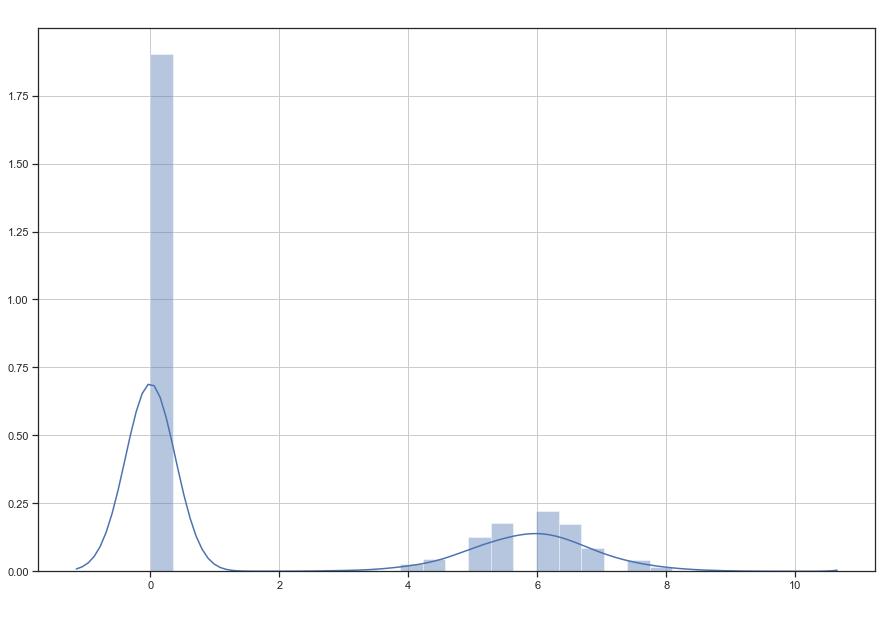

In [489]:
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.grid()
plt.xlabel('Nota', fontsize=18, color='white')
sns.distplot(cartola['nota'],hist_kws=dict(edgecolor="white")).set_title('Distribui√ß√£o de Notas', color='white', fontsize=20, fontweight="bold")

In [490]:
cartola.shape

(29184, 34)

In [491]:
cartola.describe()

atleta_id        rodada      clube_id    participou    posicao_id  \
count  29184.000000  29184.000000  29184.000000  29184.000000  29184.000000   
mean   68725.887061     18.488247    150.176467      0.362390      1.886033   
std    16655.955349     10.378876    141.539948      0.480699      2.029297   
min    36443.000000      1.000000      0.000000      0.000000      0.000000   
25%    60784.000000      9.000000      0.000000      0.000000      0.000000   
50%    72491.000000     18.000000    263.000000      0.000000      1.000000   
75%    82463.000000     27.000000    284.000000      1.000000      4.000000   
max    89898.000000     36.000000    316.000000      1.000000      6.000000   

          jogos_num    pontos_num     media_num     preco_num  variacao_num  \
count  29184.000000  29184.000000  29184.000000  29184.000000  29184.000000   
mean       6.363487      0.977100      1.588483      5.599905     -0.000048   
std        7.484913      2.768579      2.056103      4.704520      0.736660   
min        0.000000    -12.000000    -12.000000      0.760000     -7.240000   
25%        0.000000      0.000000      0.000000      2.000000      0.000000   
50%        3.000000      0.000000      0.970000      4.000000      0.000000   
75%       10.000000      0.300000      2.880000      8.000000      0.000000   
max       36.000000     31.900000     22.100000     29.610000     14.800000   

       ...            PP            RB            FC            GC  \
count  ...  29184.000000  29184.000000  29184.000000  29184.000000   
mean   ...      0.000617      0.310958      0.397272      0.000788   
std    ...      0.024828      0.832903      0.934368      0.028063   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      1.000000      9.000000     10.000000      1.000000   

                 CA            CV            SG            DD            DP  \
count  29184.000000  29184.000000  29184.000000  29184.000000  29184.000000   
mean       0.053008      0.002193      0.043483      0.034265      0.000411   
std        0.224360      0.046779      0.204113      0.291499      0.020274   
min        0.000000      0.000000     -1.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        2.000000      1.000000      1.000000      7.000000      1.000000   

                 GS  
count  29184.000000  
mean       0.027104  
std        0.238900  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        6.000000  

[8 rows x 34 columns]

In [492]:
cartola.isnull().any()

atleta_id       False
rodada          False
clube_id        False
participou      False
posicao_id      False
jogos_num       False
pontos_num      False
media_num       False
preco_num       False
variacao_num    False
partida_id      False
mando           False
titular         False
substituido     False
tempo_jogado    False
nota            False
FS              False
PE              False
A               False
FT              False
FD              False
FF              False
G               False
I               False
PP              False
RB              False
FC              False
GC              False
CA              False
CV              False
SG              False
DD              False
DP              False
GS              False
dtype: bool

# An√°lise dos Dados

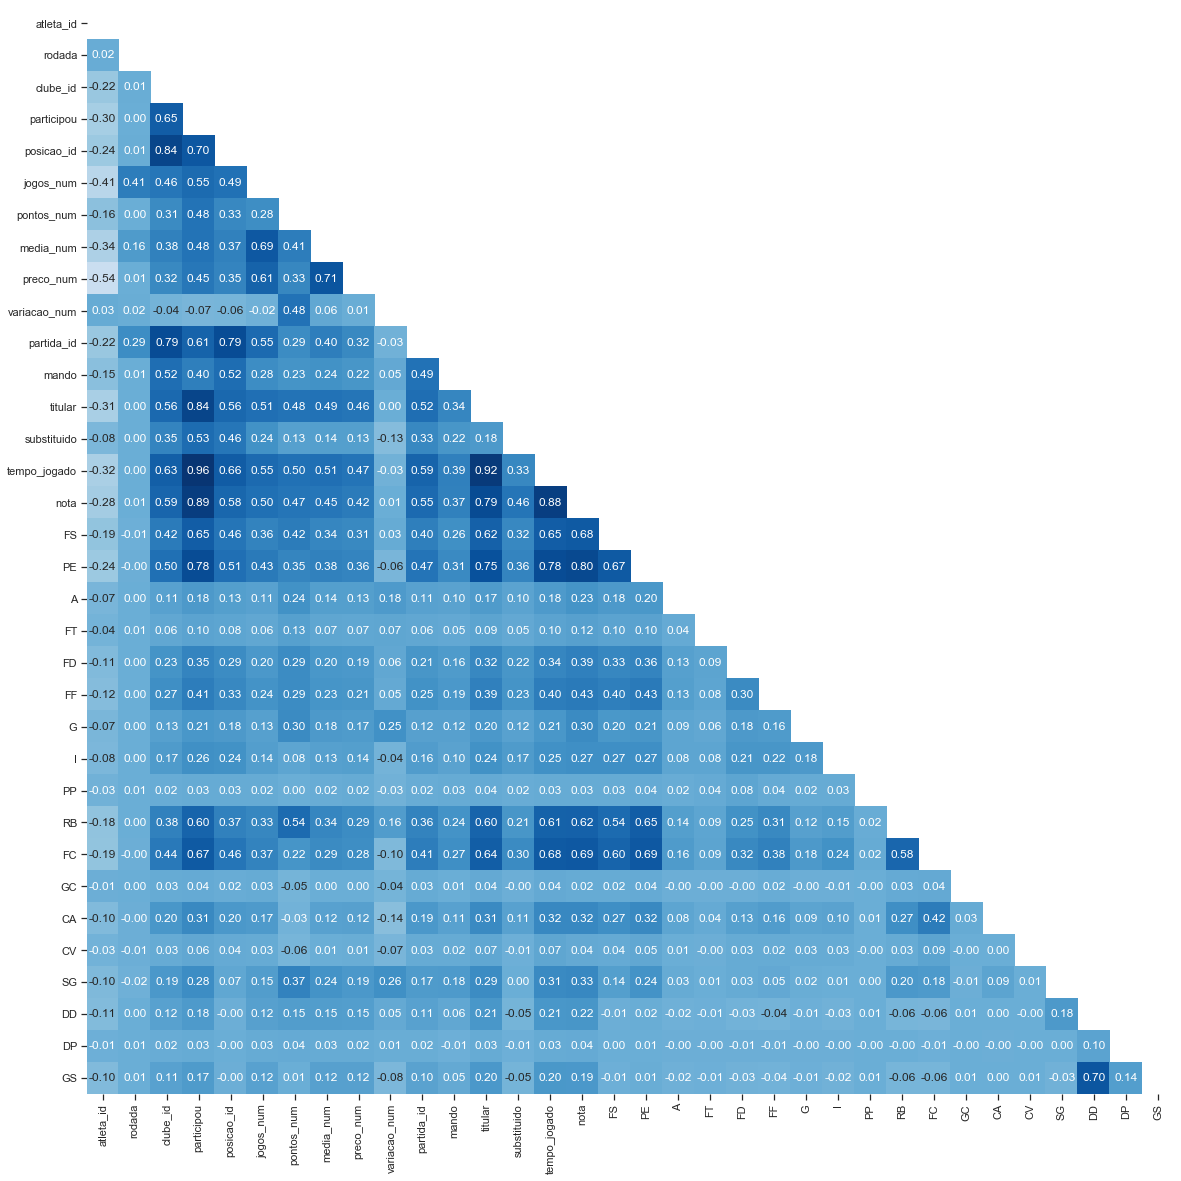

In [493]:
corr = cartola.corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots()
ax.figure.set_size_inches(20, 20)
sns.heatmap(corr, ax=ax, annot=True,  mask=mask, fmt='.2f', cbar=False, square=True, cmap=plt.cm.Blues, center=0)

Plotando a matrix de correla√ß√£o de uma forma mais eficiente podemos avaliar as altas e baixas correla√ß√µes entre todas as vari√°veis.

In [494]:
corr.style.background_gradient().set_precision(2).set_properties(**{'font-size': '8pt'})

Se observamos a vari√°vel `tempo_jogado` apresenta alta correla√ß√£o com as vari√°veis `participou` (0.95) e `titular` (0.92). O mesmo acontece para as vari√°veis `clube_id` ,`posicao_id` e `partida_id`. Em termos pr√°ticos alguns algoritmos lidam melhor quando as vari√°veis n√£o apresentam alta correla√ß√£o entre elas. As vari√°veis citadas anteriormente poderiam ent√£o ser exclu√≠das devido a sua alta correla√ß√£o, tornando o nosso futuro modelo menos inst√°vel.

Abaixo podemos ter uma vis√£o das vari√°veis altamente correlacionadas com a vari√°vel `tempo_jogado`.

In [568]:
corr['tempo_jogado'].sort_values(ascending=False)

tempo_jogado    1.000000
participou      0.955614
titular         0.920535
nota            0.884553
PE              0.778819
FC              0.675312
posicao_id      0.658058
FS              0.649539
clube_id        0.634405
RB              0.613007
partida_id      0.590513
jogos_num       0.548449
media_num       0.505286
pontos_num      0.497916
preco_num       0.471632
FF              0.404239
mando           0.385565
FD              0.339901
substituido     0.328232
CA              0.321266
SG              0.306829
I               0.252078
DD              0.209532
G               0.205565
GS              0.199697
A               0.177956
FT              0.098842
CV              0.071428
GC              0.042290
PP              0.032219
DP              0.031671
rodada          0.000361
variacao_num   -0.031340
atleta_id      -0.321096
Name: tempo_jogado, dtype: float64

Abaixo podemos ter uma vis√£o das vari√°veis melhor correlacionadas com a nossa vari√°vel alvo, `nota`.

In [569]:
corr['nota'].sort_values(ascending=False)

nota            1.000000
participou      0.886802
tempo_jogado    0.884553
PE              0.804388
titular         0.794554
FC              0.687256
FS              0.675450
RB              0.624261
clube_id        0.588712
posicao_id      0.577660
partida_id      0.549134
jogos_num       0.499720
pontos_num      0.468712
substituido     0.460132
media_num       0.454526
FF              0.434451
preco_num       0.423061
FD              0.385721
mando           0.373114
SG              0.326806
CA              0.320252
G               0.298257
I               0.270536
A               0.232345
DD              0.221173
GS              0.192247
FT              0.120239
CV              0.043405
DP              0.036911
PP              0.029064
GC              0.023037
variacao_num    0.008120
rodada          0.005669
atleta_id      -0.281441
Name: nota, dtype: float64

Por fim extraimos do conjunto de dados as vari√°veis que apresentam uma correla√ß√£o maior ou igula a 0.5 com a vari√°vel alvo, s√£o elas: `PE`, `FC`, `FS`, `RB`

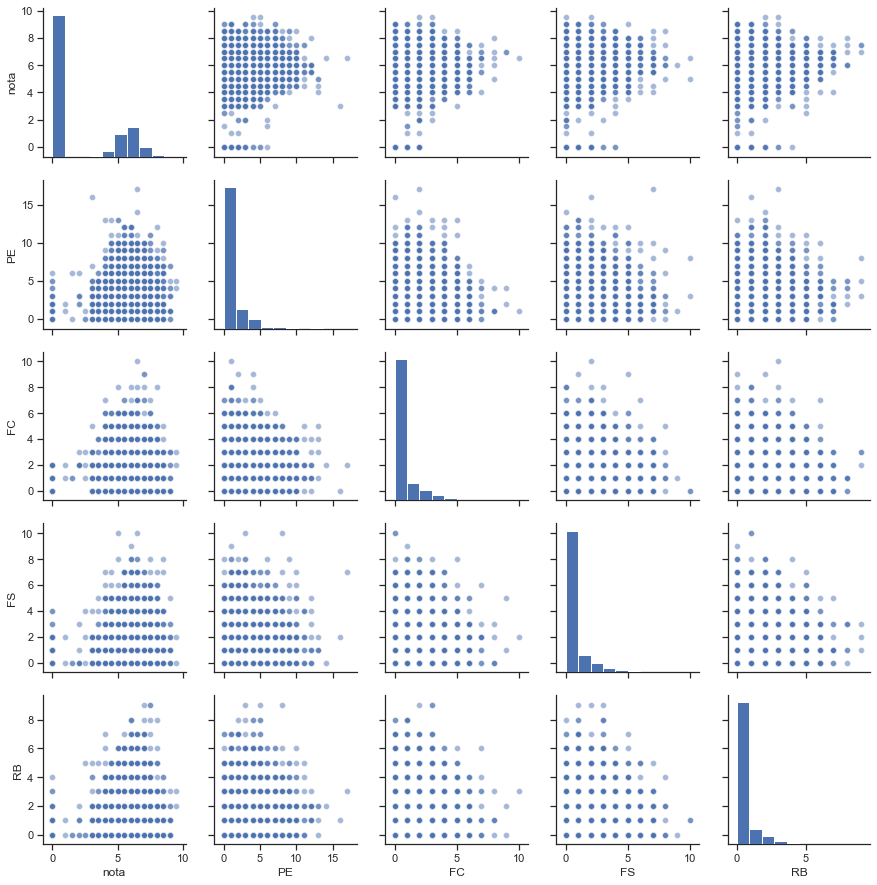

In [571]:
better_corr = cartola[['nota','PE','FC','FS','RB']]
sns.pairplot(better_corr, plot_kws = {'alpha': 0.5})

# Pre-processamento de Dados

## Aplicando a Valida√ß√£o Cruzada

In [495]:
X = cartola.drop(['nota'],axis=1)
y = cartola[['nota']]

kf = KFold(n_splits=10, random_state=42, shuffle=False)
    
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(26266, 33) (26266, 1)
(2918, 33) (2918, 1)


## Normalizando os Dados

In [496]:
norm = StandardScaler()
norm = norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [497]:
X_train_norm.shape

(26266, 33)

In [498]:
X_test_norm.shape

(2918, 33)

## Modelo de Regress√£o Ridge

In [499]:
# def ridge_regression_model(X,Y, l2_penalty):
#     model = Ridge(alpha=l2_penalty)
#     model.fit(X,Y)
#     return model

In [500]:
# from sklearn.model_selection import cross_val_score
# def rmse_cv(model):
#     rmse = np.sqrt(-cross_val_score(model,X_train_norm,y_train,scoring="neg_mean_squared_error",cv=10))
#     return (rmse)

In [501]:
# l2_penalties = [0.001,0.01,0.1,0.3,0.5,1,3,5,10,15,20,40,60,80,100]
# cv_ridge = [rmse_cv(Ridge(alpha=l2_penalty)).mean() for l2_penalty in l2_penalties]
# cv_ridge = pd.Series(cv_ridge,index=l2_penalties)
# cv_ridge.head()

In [502]:
# plt.figure(figsize=(15,10))
# cv_ridge.plot(title="Lambda vs Erro de Valida√ß√£o",fontsize=15)
# plt.tight_layout()
# plt.grid()
# plt.xlabel("L2 Penalty")
# plt.ylabel("RMSE")

In [503]:
# best_l2_penalty=cv_ridge.values.argmin()
# best_rmse = cv_ridge.min()

# # melhor valor de (alpha,rmse) encontrado
# print (best_l2_penalty, best_rmse) 

In [504]:
# ridge_model = ridge_regression_model(X_test_norm,y_test,l2_penalty=best_l2_penalty)

# ridge_train_score = ridge_model.score(X_train_norm,y_train)
# ridge_test_score = ridge_model.score(X_test_norm, y_test)

# # print ("Ridge Model Coeficients:", ridge_model.coef_)
# print ("Ridge Regression train score:", ridge_train_score)
# print ("Ridge Regression test score:", ridge_test_score)

In [505]:
# y_pred = ridge_model.predict(X_test_norm)

In [506]:
# df_ridge_results = pd.DataFrame({'Actual': y_test[y_test.columns[0]], 'Predicted': y_pred.flatten()})
# df_ridge_results.head(10)

## Modelo de Regress√£o Lasso

In [507]:
# def lasso_regression_model(X, Y, l1_penalty):
#     model = Lasso(alpha=l1_penalty, max_iter=10000)
#     model.fit(X,Y)
#     return model

In [508]:
# from sklearn.model_selection import cross_val_score
# def rmse_cv(model):
#     rmse = np.sqrt(-cross_val_score(model,X_train_norm,y_train,scoring="neg_mean_squared_error",cv=10))
#     return (rmse)

In [509]:
# l1_penalties = [0.00001, 0.0001, 0.001, 0.01, 0.1, 10]
# cv_lasso = [rmse_cv(Lasso(alpha=l1_penalty)).mean() for l1_penalty in l1_penalties]
# cv_lasso = pd.Series(cv_lasso,index=l1_penalties)
# cv_lasso.head()

In [510]:
# plt.figure(figsize=(15,10))
# cv_lasso.plot(title="Lambda vs Erro de Valida√ß√£o",fontsize=15)
# plt.tight_layout()
# plt.grid()
# plt.xlabel("L2 Penalty")
# plt.ylabel("RMSE")

In [511]:
# best_l1_penalty=cv_lasso.values.argmin()
# best_rmse = cv_lasso.min()

# # melhor valor de (alpha,rmse) encontrado
# print (best_l1_penalty, best_rmse) 

In [512]:
# lasso_model = lasso_regression_model(X_test_norm,y_test,l1_penalty=best_l1_penalty)

# lasso_train_score = lasso_model.score(X_train_norm,y_train)
# lasso_test_score = lasso_model.score(X_test_norm, y_test)

# print ("Lasso Model Coeficients:", lasso_model.coef_)
# print ("Lasso Regression train score:", ridge_train_score)
# print ("Lasso Regression test score:", ridge_test_score)

In [513]:
# names = X.columns

# for c, att in zip(lasso_model.coef_, names):
#     print('{}: {}'.format(att, round(c, 3)))

# Pipelines

## Pipeline and Parameters - Ridge

A regress√£o ridge se prop√µe a evitar o overfitting adicionando um custo ao RSS (dos m√≠nimos quadrados) que depende da norma L2 dos coeficientes  ‚Äñùë§‚Äñ  (ou seja da magnitude dos coeficientes). O resultado √© a penaliza√ß√£o de ajustes com coeficientes muito grandes. A for√ßa dessa penalidade √© controlada por um par√¢metro lambda (aqui chamado "L2_penalty").



A regress√£o Ridge √© um m√©todo de regulariza√ß√£o do modelo que tem como principal objetivo suavizar atributos que sejam relacionados uns aos outros e que aumentam o ru√≠do no modelo, tamb√©m conhecido como multicolinearidade. Com isso com a retirada de determinados atributos do modelo, o mesmo converge para um resultado muito mais est√°vel em que com a redu√ß√£o desses atributos, a redu√ß√£o em termos de acur√°cia do modelo se mant√™m inalterada. O mecanismo algoritmico que faz isso √© atrav√©s de um mecanismo de penaliza√ß√£o que coloca um vi√©s e que vai reduzindo os valores os betas at√© n√£o zero. Com isso os atributos que contribuem menos para o poder preditivo do modelo s√£o levados para a irrelev√¢ncia usando esse mecanismo de penaliza√ß√£o do vi√©s.

In [514]:
pipe_ridge = Pipeline([('scl', StandardScaler()),('clf', Ridge())])

l2_penalty = {'clf__alpha': [0.001,0.01,0.1,0.3,0.5,1,3,5,10,15,20,40,60,80,100]}

In [515]:
# model(pipe_ridge, l2_penalty, X_train_norm, y_train, X_test_norm, y_test)
ridge_results, ridge_grid_obj = get_results(pipe_ridge, l2_penalty, X_train_norm, y_train, X_test_norm, y_test)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] clf__alpha=0.001 ................................................
[CV] ................................. clf__alpha=0.001, total=   0.1s
[CV] clf__alpha=0.001 ................................................
[CV] ................................. clf__alpha=0.001, total=   0.1s
[CV] clf__alpha=0.001 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................................. clf__alpha=0.001, total=   0.1s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.1s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.1s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.1s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.1s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.1s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.2s
[CV] clf__alpha=0.3 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    3.2s finished


In [516]:
ridge_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.077182      0.016518         0.014353        0.005129   
1       0.068807      0.008517         0.009755        0.004694   
2       0.101756      0.058602         0.010537        0.006569   
3       0.039969      0.001649         0.004802        0.000056   
4       0.040180      0.002316         0.005318        0.000289   

  param_clf__alpha                 params  split0_test_score  \
0            0.001  {'clf__alpha': 0.001}           0.906497   
1             0.01   {'clf__alpha': 0.01}           0.906497   
2              0.1    {'clf__alpha': 0.1}           0.906493   
3              0.3    {'clf__alpha': 0.3}           0.906485   
4              0.5    {'clf__alpha': 0.5}           0.906477   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.913437           0.912791         0.910908        0.003130   
1           0.913437           0.912791         0.910908        0.003131   
2           0.913438           0.912793         0.910908        0.003133   
3           0.913442           0.912796         0.910908        0.003138   
4           0.913445           0.912800         0.910907        0.003143   

   rank_test_score  
0                1  
1                2  
2                3  
3                4  
4                5

In [517]:
print("best_index", ridge_grid_obj.best_index_)
print("best_score", ridge_grid_obj.best_score_)
print("best_params", ridge_grid_obj.best_params_)

best_index 0
best_score 0.9109080104362963
best_params {'clf__alpha': 0.001}


In [518]:
ridge_estimator = ridge_grid_obj.best_estimator_
'''
if estimator.named_steps['scl'] == True:
    X = (X - X.mean()) / (X.std())
    y = (y - y.mean()) / (y.std())
'''
shuffle = KFold(n_splits=5,
                shuffle=True,
                random_state=0)
cv_scores = cross_val_score(ridge_estimator, X_test_norm, y_test.values.ravel(), cv=shuffle, scoring='r2')
print("Mean Score", cv_scores.mean())

Mean Score 0.9023776221727692


In [519]:
y_pred_train = cross_val_predict(ridge_estimator, X_train_norm, y_train, cv=shuffle)
train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('RMSE on Training Set:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

RMSE on Training Set: 0.8391557501913214


In [520]:
df_ridge_train = pd.DataFrame({'Actual': y_train['nota'], 'Predict': y_pred_train.flatten()})
df_ridge_train.head(10)

Actual   Predict
0     6.0  6.290144
1     0.0  0.465709
2     6.0  6.177632
3     0.0  0.308282
4     6.0  6.193442
5     6.0  6.170761
6     0.0  0.152367
7     6.0  5.386845
8     5.5  5.326323
9     4.0  4.416269

In [521]:
y_pred_test = cross_val_predict(ridge_estimator, X_test_norm, y_test, cv=shuffle)
test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('RMSE on Test Set:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

RMSE on Test Set: 0.8646499223973276


In [522]:
df_ridge_test = pd.DataFrame({'Actual': y_test['nota'], 'Predict': y_pred_test.flatten()})
df_ridge_test.head(10)

Actual   Predict
26266     6.0  6.845079
26267     4.5  5.876529
26268     7.5  5.724039
26269     5.5  5.761054
26270     8.0  8.396190
26271     0.0  3.580518
26272     8.0  7.571346
26273     0.0  0.004910
26274     0.0 -0.028421
26275     5.5  5.023671

## Pipeline and Parameters - Lasso

A regress√£o Lasso, ao mesmo tempo, encolhe a magnitude dos coeficientes para evitar o overfitting e realiza implicitamente sele√ß√£o de caracter√≠stcas igualando alguns atributos a zero (para lambdas, aqui chamados "L1_penalty", suficientemente grandes). Em particular, o Lasso adiciona ao RSS o custo $\|w\|$.

A regres√£o Lasso, assim como a Ridge, tem o mesmo mecanismo de penaliza√ß√£o dos coeficientes com um alto grau de correla√ß√£o entre si, mas que usa o mecanismo de penalizar os coeficientes de acordo com o seu valor absoluto (soma dos valores dos estimadores) usando o mecanismo de minimizar o erro quadr√°tico. Isso √© feito atrav√©s da penaliza√ß√£o do coeficiente at√© que o mesmo convirja para zero; o que naturalmente vai eliminar o atributo e reduzir a dimensionalidade do modelo.

In [523]:
pipe_lasso = Pipeline([('scl', StandardScaler()), ('clf', Lasso(max_iter=1500))])

l1_penalty = {'clf__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 10]}

In [524]:
# APAGAAAAR APENAS TESTE
# model(pipe_lasso, l1_penalty, X_train_norm, y_train, X_test_norm, y_test)

In [525]:
lasso_results, lasso_grid_obj = get_results(pipe_lasso, l1_penalty, X_train_norm, y_train, X_test_norm, y_test)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__alpha=1e-05 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. clf__alpha=1e-05, total=   4.6s
[CV] clf__alpha=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] ................................. clf__alpha=1e-05, total=   2.3s
[CV] clf__alpha=1e-05 ................................................
[CV] ................................. clf__alpha=1e-05, total=   2.6s
[CV] clf__alpha=0.0001 ...............................................
[CV] ................................ clf__alpha=0.0001, total=   1.5s
[CV] clf__alpha=0.0001 ...............................................
[CV] ................................ clf__alpha=0.0001, total=   1.3s
[CV] clf__alpha=0.0001 ...............................................
[CV] ................................ clf__alpha=0.0001, total=   1.4s
[CV] clf__alpha=0.001 ................................................
[CV] ................................. clf__alpha=0.001, total=   0.6s
[CV] clf__alpha=0.001 ................................................
[CV] ................................. clf__alpha=0.001, total=   0.8s
[CV] clf__alpha=0.001 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   18.1s finished


In [526]:
lasso_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1       1.412909      0.100021         0.005365        0.000222   
0       3.176813      1.044160         0.005778        0.000319   
2       0.596113      0.165059         0.005426        0.000360   
3       0.640941      0.326333         0.006235        0.001633   
4       0.100346      0.003898         0.005807        0.000721   

  param_clf__alpha                  params  split0_test_score  \
1           0.0001  {'clf__alpha': 0.0001}           0.906448   
0            1e-05   {'clf__alpha': 1e-05}           0.906492   
2            0.001   {'clf__alpha': 0.001}           0.905929   
3             0.01    {'clf__alpha': 0.01}           0.893444   
4              0.1     {'clf__alpha': 0.1}           0.845236   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
1           0.913449           0.912832         0.910910        0.003165   
0           0.913438           0.912795         0.910908        0.003134   
2           0.913483           0.912999         0.910804        0.003453   
3           0.906463           0.905880         0.901929        0.006005   
4           0.864253           0.861040         0.856842        0.008311   

   rank_test_score  
1                1  
0                2  
2                3  
3                4  
4                5

In [527]:
print("best_index", lasso_grid_obj.best_index_)
print("best_score", lasso_grid_obj.best_score_)
print("best_params", lasso_grid_obj.best_params_)

best_index 1
best_score 0.9109095080504517
best_params {'clf__alpha': 0.0001}


In [528]:
lasso_estimator = lasso_grid_obj.best_estimator_

shuffle = KFold(n_splits=5,
                shuffle=True,
                random_state=0)
cv_scores = cross_val_score(lasso_estimator, X_test_norm, y_test.values.ravel(), cv=shuffle, scoring='r2')
print("Mean Score", cv_scores.mean())

Mean Score 0.9024291844254473


In [529]:
y_pred_train = cross_val_predict(lasso_estimator, X_train_norm, y_train, cv=shuffle)
train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('RMSE on Training Set:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

RMSE on Training Set: 0.839137700237173


In [530]:
df_lasso_train = pd.DataFrame({'Actual': y_train['nota'], 'Predict': y_pred_train.flatten()})
df_lasso_train.head(10)

Actual   Predict
0     6.0  6.281874
1     0.0  0.465936
2     6.0  6.176376
3     0.0  0.303934
4     6.0  6.188928
5     6.0  6.165706
6     0.0  0.147475
7     6.0  5.380677
8     5.5  5.322499
9     4.0  4.419491

In [531]:
y_pred_test = cross_val_predict(lasso_estimator, X_test_norm, y_test, cv=shuffle)
test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('RMSE on Test Set:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

RMSE on Test Set: 0.8644157621017611


In [532]:
df_lasso_test = pd.DataFrame({'Actual': y_test['nota'], 'Predict': y_pred_test.flatten()})
df_lasso_test.head(10)

Actual   Predict
26266     6.0  6.845398
26267     4.5  5.879006
26268     7.5  5.719789
26269     5.5  5.758630
26270     8.0  8.397172
26271     0.0  3.578659
26272     8.0  7.567428
26273     0.0  0.004557
26274     0.0 -0.028871
26275     5.5  5.018486

In [533]:
features_coefficients(lasso_estimator)


##### Model coefficients: #####
atleta_id: 0.013
rodada: -0.0
clube_id: 0.002
participou: 0.813
posicao_id: -0.337
jogos_num: 0.023
pontos_num: -2.633
media_num: -0.031
preco_num: 0.041
variacao_num: -0.012
partida_id: 0.268
mando: 0.046
titular: -0.655
substituido: 0.531
tempo_jogado: 1.989
FS: 0.52
PE: -0.409
A: 0.812
FT: 0.291
FD: 0.383
FF: 0.32
G: 1.577
I: -0.134
PP: -0.1
RB: 1.455
FC: -0.377
GC: -0.194
CA: -0.424
CV: -0.31
SG: 1.08
DD: 0.971
DP: 0.152
GS: -0.476

##### Feature importances: #####

Model does not support feature importances


## Pipeline and Parameters - Knn

In [534]:
pipe_knn = Pipeline([('clf', KNeighborsRegressor())])

param_knn = {'clf__n_neighbors':[5, 10, 15, 25, 30]}

In [535]:
# model(pipe_knn, param_knn, X_train, y_train, X_test_norm, y_test)

In [536]:
knn_results, knn_grid_obj = get_results(pipe_knn, param_knn, X_train_norm, y_train, X_test_norm, y_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__n_neighbors=5 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... clf__n_neighbors=5, total=   4.0s
[CV] clf__n_neighbors=5 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] ............................... clf__n_neighbors=5, total=   4.7s
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=   4.7s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=   4.2s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=   5.6s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=   4.8s
[CV] clf__n_neighbors=15 .............................................
[CV] .............................. clf__n_neighbors=15, total=   4.4s
[CV] clf__n_neighbors=15 .............................................
[CV] .............................. clf__n_neighbors=15, total=   6.6s
[CV] clf__n_neighbors=15 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.3min finished


In [537]:
print("best_index", knn_grid_obj.best_index_)
print("best_score", knn_grid_obj.best_score_)
print("best_params", knn_grid_obj.best_params_)

best_index 2
best_score 0.9283537936945819
best_params {'clf__n_neighbors': 15}


In [538]:
knn_estimator = knn_grid_obj.best_estimator_

shuffle = KFold(n_splits=5,
                shuffle=True,
                random_state=0)
cv_scores = cross_val_score(knn_estimator, X_test_norm, y_test.values.ravel(), cv=shuffle, scoring='r2')
print("Mean Score", cv_scores.mean())

Mean Score 0.9182431470274345


In [539]:
y_pred_train = cross_val_predict(knn_estimator, X_train_norm, y_train, cv=shuffle)
train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('RMSE on Training Set:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

RMSE on Training Set: 0.722101325265847


In [540]:
df_knn_train = pd.DataFrame({'Actual': y_train['nota'], 'Predict': y_pred_train.flatten()})
df_knn_train.head(10)

Actual   Predict
0     6.0  6.600000
1     0.0  0.000000
2     6.0  5.900000
3     0.0  0.000000
4     6.0  6.333333
5     6.0  6.133333
6     0.0  0.000000
7     6.0  6.000000
8     5.5  5.533333
9     4.0  4.966667

In [541]:
y_pred_test = cross_val_predict(knn_estimator, X_test_norm, y_test, cv=shuffle)
test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('RMSE on Test Set:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

RMSE on Test Set: 0.7919515077437649


In [542]:
df_knn_test = pd.DataFrame({'Actual': y_test['nota'], 'Predict': y_pred_test.flatten()})
df_knn_test.head(10)

Actual   Predict
26266     6.0  6.133333
26267     4.5  5.833333
26268     7.5  6.133333
26269     5.5  5.866667
26270     8.0  6.766667
26271     0.0  4.366667
26272     8.0  7.033333
26273     0.0  0.000000
26274     0.0  0.000000
26275     5.5  4.900000

## Show model coefficients or feature importances

In [543]:
features_coefficients(knn_estimator)


##### Model coefficients: #####

Model does not support model coefficients

##### Feature importances: #####

Model does not support feature importances


## Pipeline and Parameters - Decision Tree Regression

In [544]:
pipe_tree = Pipeline([('clf', DecisionTreeRegressor())])

param_tree = {'clf__max_depth': [2, 5, 10], 'clf__min_samples_leaf': [5,10,50,100]}

In [545]:
# model(pipe_tree, param_tree, X_train_norm, y_train, X_test_norm, y_test)

In [546]:
tree_results, tree_grid_obj = get_results(pipe_tree, param_tree, X_train_norm, y_train, X_test_norm, y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__max_depth=2, clf__min_samples_leaf=5 .......................
[CV] ........ clf__max_depth=2, clf__min_samples_leaf=5, total=   0.1s
[CV] clf__max_depth=2, clf__min_samples_leaf=5 .......................
[CV] ........ clf__max_depth=2, clf__min_samples_leaf=5, total=   0.1s
[CV] clf__max_depth=2, clf__min_samples_leaf=5 .......................
[CV] ........ clf__max_depth=2, clf__min_samples_leaf=5, total=   0.1s
[CV] clf__max_depth=2, clf__min_samples_leaf=10 ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ....... clf__max_depth=2, clf__min_samples_leaf=10, total=   0.1s
[CV] clf__max_depth=2, clf__min_samples_leaf=10 ......................
[CV] ....... clf__max_depth=2, clf__min_samples_leaf=10, total=   0.1s
[CV] clf__max_depth=2, clf__min_samples_leaf=10 ......................
[CV] ....... clf__max_depth=2, clf__min_samples_leaf=10, total=   0.0s
[CV] clf__max_depth=2, clf__min_samples_leaf=50 ......................
[CV] ....... clf__max_depth=2, clf__min_samples_leaf=50, total=   0.0s
[CV] clf__max_depth=2, clf__min_samples_leaf=50 ......................
[CV] ....... clf__max_depth=2, clf__min_samples_leaf=50, total=   0.0s
[CV] clf__max_depth=2, clf__min_samples_leaf=50 ......................
[CV] ....... clf__max_depth=2, clf__min_samples_leaf=50, total=   0.1s
[CV] clf__max_depth=2, clf__min_samples_leaf=100 .....................
[CV] ...... clf__max_depth=2, clf__min_samples_leaf=100, total=   0.1s
[CV] clf__max_depth=2, clf__min_samples_leaf=100 .....................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    2.7s finished


In [547]:
tree_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
11       0.090864      0.022344         0.003898        0.000990   
10       0.082276      0.008641         0.003185        0.000661   
7        0.063051      0.015478         0.003075        0.000652   
6        0.060728      0.007249         0.003241        0.000417   
5        0.057078      0.011478         0.002925        0.000527   

   param_clf__max_depth param_clf__min_samples_leaf  \
11                   10                         100   
10                   10                          50   
7                     5                         100   
6                     5                          50   
5                     5                          10   

                                               params  split0_test_score  \
11  {'clf__max_depth': 10, 'clf__min_samples_leaf'...           0.948025   
10  {'clf__max_depth': 10, 'clf__min_samples_leaf'...           0.947209   
7   {'clf__max_depth': 5, 'clf__min_samples_leaf':...           0.947468   
6   {'clf__max_depth': 5, 'clf__min_samples_leaf':...           0.947146   
5   {'clf__max_depth': 5, 'clf__min_samples_leaf':...           0.947356   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
11           0.947956           0.947538         0.947840        0.000215   
10           0.948123           0.947375         0.947569        0.000397   
7            0.946486           0.945952         0.946635        0.000628   
6            0.945686           0.946110         0.946314        0.000613   
5            0.944386           0.944475         0.945406        0.001380   

    rank_test_score  
11                1  
10                2  
7                 3  
6                 4  
5                 5

In [548]:
print("best_index", tree_grid_obj.best_index_)
print("best_score", tree_grid_obj.best_score_)
print("best_params", tree_grid_obj.best_params_)

best_index 11
best_score 0.9478396661818563
best_params {'clf__max_depth': 10, 'clf__min_samples_leaf': 100}


In [549]:
tree_estimator = tree_grid_obj.best_estimator_

shuffle = KFold(n_splits=5,
                shuffle=True,
                random_state=0)
cv_scores = cross_val_score(tree_estimator, X_test_norm, y_test.values.ravel(), cv=shuffle, scoring='r2')
print("Mean Score", cv_scores.mean())

Mean Score 0.8659501154782591


In [550]:
y_pred_train = cross_val_predict(tree_estimator, X_train_norm, y_train, cv=shuffle)
train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('RMSE on Training Set:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

RMSE on Training Set: 0.6437191982398572


In [551]:
df_tree_train = pd.DataFrame({'Actual': y_test['nota'], 'Predict': y_pred_test.flatten()})
df_tree_train.head(10)

Actual   Predict
26266     6.0  6.133333
26267     4.5  5.833333
26268     7.5  6.133333
26269     5.5  5.866667
26270     8.0  6.766667
26271     0.0  4.366667
26272     8.0  7.033333
26273     0.0  0.000000
26274     0.0  0.000000
26275     5.5  4.900000

In [552]:
y_pred_test = cross_val_predict(tree_estimator, X_test_norm, y_test, cv=shuffle)
test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('RMSE on Test Set:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

RMSE on Test Set: 1.0114413384213408


In [553]:
df_tree_test = pd.DataFrame({'Actual': y_test['nota'], 'Predict': y_pred_test.flatten()})
df_tree_test.head(10)

Actual   Predict
26266     6.0  6.747899
26267     4.5  5.333333
26268     7.5  6.805785
26269     5.5  5.657576
26270     8.0  6.777344
26271     0.0  4.931624
26272     8.0  6.777344
26273     0.0  0.364486
26274     0.0  0.047170
26275     5.5  5.524752

## Show model coefficients or feature importances

In [554]:
features_coefficients(tree_estimator)


##### Model coefficients: #####

Model does not support model coefficients

##### Feature importances: #####
atleta_id: 0.0
rodada: 0.0
clube_id: 0.001
participou: 0.003
posicao_id: 0.103
jogos_num: 0.0
pontos_num: 0.011
media_num: 0.0
preco_num: 0.0
variacao_num: 0.0
partida_id: 0.0
mando: 0.0
titular: 0.0
substituido: 0.0
tempo_jogado: 0.88
FS: 0.0
PE: 0.0
A: 0.0
FT: 0.0
FD: 0.0
FF: 0.0
G: 0.001
I: 0.0
PP: 0.0
RB: 0.001
FC: 0.0
GC: 0.0
CA: 0.0
CV: 0.0
SG: 0.0
DD: 0.0
DP: 0.0
GS: 0.0


## Pipeline and Parameters - Random Forest

In [555]:
pipe_forest = Pipeline([('clf', RandomForestRegressor())])

param_forest = {'clf__n_estimators': [10, 20, 50],
                'clf__max_features': [None, 1, 2],
                'clf__max_depth': [1, 2, 5]}

In [556]:
# model(pipe_forest, param_forest, X_train_norm, y_train, X_test_norm, y_test)

In [557]:
forest_results, forest_grid_obj = get_results(pipe_forest, param_forest, X_train_norm, y_train, X_test_norm, y_test)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=10 ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=10, total=   0.2s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=10 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=10, total=   0.2s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=10 ..


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=10, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=20 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=20, total=   0.2s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=20 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=20, total=   0.2s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=20 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=20, total=   0.2s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=50 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=50, total=   0.5s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=50 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=50, total=   0.5s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=50 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=50, total=   0.5s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=10 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=10 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=10 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=20 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=20 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/s

[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=20 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=50 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=50, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=50 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=50, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=50 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=50, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=2, clf__n_estimators=10 .....
[CV]  clf__max_depth=1, clf__max_features=2, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=2, clf__n_estimators=10 .....
[CV]  clf__max_depth=1, clf__max_features=2, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=2, clf__n_estimators=10 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/s

[CV]  clf__max_depth=1, clf__max_features=2, clf__n_estimators=10, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=2, clf__n_estimators=20 .....
[CV]  clf__max_depth=1, clf__max_features=2, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=2, clf__n_estimators=20 .....
[CV]  clf__max_depth=1, clf__max_features=2, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=2, clf__n_estimators=20 .....
[CV]  clf__max_depth=1, clf__max_features=2, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=2, clf__n_estimators=50 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/s

[CV]  clf__max_depth=1, clf__max_features=2, clf__n_estimators=50, total=   0.2s
[CV] clf__max_depth=1, clf__max_features=2, clf__n_estimators=50 .....
[CV]  clf__max_depth=1, clf__max_features=2, clf__n_estimators=50, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=2, clf__n_estimators=50 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=1, clf__max_features=2, clf__n_estimators=50, total=   0.2s
[CV] clf__max_depth=2, clf__max_features=None, clf__n_estimators=10 ..
[CV]  clf__max_depth=2, clf__max_features=None, clf__n_estimators=10, total=   0.2s
[CV] clf__max_depth=2, clf__max_features=None, clf__n_estimators=10 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=2, clf__max_features=None, clf__n_estimators=10, total=   0.2s
[CV] clf__max_depth=2, clf__max_features=None, clf__n_estimators=10 ..
[CV]  clf__max_depth=2, clf__max_features=None, clf__n_estimators=10, total=   0.2s
[CV] clf__max_depth=2, clf__max_features=None, clf__n_estimators=20 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=2, clf__max_features=None, clf__n_estimators=20, total=   0.3s
[CV] clf__max_depth=2, clf__max_features=None, clf__n_estimators=20 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=2, clf__max_features=None, clf__n_estimators=20, total=   0.3s
[CV] clf__max_depth=2, clf__max_features=None, clf__n_estimators=20 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=2, clf__max_features=None, clf__n_estimators=20, total=   0.3s
[CV] clf__max_depth=2, clf__max_features=None, clf__n_estimators=50 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=2, clf__max_features=None, clf__n_estimators=50, total=   0.8s
[CV] clf__max_depth=2, clf__max_features=None, clf__n_estimators=50 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=2, clf__max_features=None, clf__n_estimators=50, total=   0.8s
[CV] clf__max_depth=2, clf__max_features=None, clf__n_estimators=50 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=2, clf__max_features=None, clf__n_estimators=50, total=   1.0s
[CV] clf__max_depth=2, clf__max_features=1, clf__n_estimators=10 .....
[CV]  clf__max_depth=2, clf__max_features=1, clf__n_estimators=10, total=   0.1s
[CV] clf__max_depth=2, clf__max_features=1, clf__n_estimators=10 .....
[CV]  clf__max_depth=2, clf__max_features=1, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=2, clf__max_features=1, clf__n_estimators=10 .....
[CV]  clf__max_depth=2, clf__max_features=1, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=2, clf__max_features=1, clf__n_estimators=20 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/s

[CV]  clf__max_depth=2, clf__max_features=1, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=2, clf__max_features=1, clf__n_estimators=20 .....
[CV]  clf__max_depth=2, clf__max_features=1, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=2, clf__max_features=1, clf__n_estimators=20 .....
[CV]  clf__max_depth=2, clf__max_features=1, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=2, clf__max_features=1, clf__n_estimators=50 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=2, clf__max_features=1, clf__n_estimators=50, total=   0.2s
[CV] clf__max_depth=2, clf__max_features=1, clf__n_estimators=50 .....
[CV]  clf__max_depth=2, clf__max_features=1, clf__n_estimators=50, total=   0.2s
[CV] clf__max_depth=2, clf__max_features=1, clf__n_estimators=50 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=2, clf__max_features=1, clf__n_estimators=50, total=   0.3s
[CV] clf__max_depth=2, clf__max_features=2, clf__n_estimators=10 .....
[CV]  clf__max_depth=2, clf__max_features=2, clf__n_estimators=10, total=   0.1s
[CV] clf__max_depth=2, clf__max_features=2, clf__n_estimators=10 .....
[CV]  clf__max_depth=2, clf__max_features=2, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=2, clf__max_features=2, clf__n_estimators=10 .....
[CV]  clf__max_depth=2, clf__max_features=2, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=2, clf__max_features=2, clf__n_estimators=20 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/s

[CV]  clf__max_depth=2, clf__max_features=2, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=2, clf__max_features=2, clf__n_estimators=20 .....
[CV]  clf__max_depth=2, clf__max_features=2, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=2, clf__max_features=2, clf__n_estimators=20 .....
[CV]  clf__max_depth=2, clf__max_features=2, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=2, clf__max_features=2, clf__n_estimators=50 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=2, clf__max_features=2, clf__n_estimators=50, total=   0.2s
[CV] clf__max_depth=2, clf__max_features=2, clf__n_estimators=50 .....
[CV]  clf__max_depth=2, clf__max_features=2, clf__n_estimators=50, total=   0.2s
[CV] clf__max_depth=2, clf__max_features=2, clf__n_estimators=50 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=2, clf__max_features=2, clf__n_estimators=50, total=   0.2s
[CV] clf__max_depth=5, clf__max_features=None, clf__n_estimators=10 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=None, clf__n_estimators=10, total=   0.3s
[CV] clf__max_depth=5, clf__max_features=None, clf__n_estimators=10 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=None, clf__n_estimators=10, total=   0.3s
[CV] clf__max_depth=5, clf__max_features=None, clf__n_estimators=10 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=None, clf__n_estimators=10, total=   0.3s
[CV] clf__max_depth=5, clf__max_features=None, clf__n_estimators=20 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=None, clf__n_estimators=20, total=   0.6s
[CV] clf__max_depth=5, clf__max_features=None, clf__n_estimators=20 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=None, clf__n_estimators=20, total=   0.6s
[CV] clf__max_depth=5, clf__max_features=None, clf__n_estimators=20 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=None, clf__n_estimators=20, total=   0.5s
[CV] clf__max_depth=5, clf__max_features=None, clf__n_estimators=50 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=None, clf__n_estimators=50, total=   1.5s
[CV] clf__max_depth=5, clf__max_features=None, clf__n_estimators=50 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=None, clf__n_estimators=50, total=   1.6s
[CV] clf__max_depth=5, clf__max_features=None, clf__n_estimators=50 ..


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=None, clf__n_estimators=50, total=   1.4s
[CV] clf__max_depth=5, clf__max_features=1, clf__n_estimators=10 .....
[CV]  clf__max_depth=5, clf__max_features=1, clf__n_estimators=10, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=1, clf__n_estimators=10 .....
[CV]  clf__max_depth=5, clf__max_features=1, clf__n_estimators=10, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=1, clf__n_estimators=10 .....
[CV]  clf__max_depth=5, clf__max_features=1, clf__n_estimators=10, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=1, clf__n_estimators=20 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/s

[CV]  clf__max_depth=5, clf__max_features=1, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=1, clf__n_estimators=20 .....
[CV]  clf__max_depth=5, clf__max_features=1, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=1, clf__n_estimators=20 .....
[CV]  clf__max_depth=5, clf__max_features=1, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=1, clf__n_estimators=50 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=1, clf__n_estimators=50, total=   0.2s
[CV] clf__max_depth=5, clf__max_features=1, clf__n_estimators=50 .....
[CV]  clf__max_depth=5, clf__max_features=1, clf__n_estimators=50, total=   0.2s
[CV] clf__max_depth=5, clf__max_features=1, clf__n_estimators=50 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=1, clf__n_estimators=50, total=   0.3s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=10 .....
[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=10, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=10 .....
[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=10, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=10 .....
[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=10, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=20 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/s

[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=20 .....
[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=20 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=50 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=50, total=   0.3s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=50 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=50, total=   0.3s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=50 .....


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=50, total=   0.3s


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   19.9s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [558]:
forest_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
20       1.486954      0.103887         0.017591        0.000318   
19       0.567567      0.022453         0.008994        0.000503   
18       0.298634      0.005728         0.006179        0.000204   
11       0.815762      0.079841         0.021242        0.006268   
10       0.311760      0.001675         0.006693        0.000020   

   param_clf__max_depth param_clf__max_features param_clf__n_estimators  \
20                    5                    None                      50   
19                    5                    None                      20   
18                    5                    None                      10   
11                    2                    None                      50   
10                    2                    None                      20   

                                               params  split0_test_score  \
20  {'clf__max_depth': 5, 'clf__max_features': Non...           0.950043   
19  {'clf__max_depth': 5, 'clf__max_features': Non...           0.949496   
18  {'clf__max_depth': 5, 'clf__max_features': Non...           0.949143   
11  {'clf__max_depth': 2, 'clf__max_features': Non...           0.931920   
10  {'clf__max_depth': 2, 'clf__max_features': Non...           0.931658   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
20           0.949189           0.945220         0.948151        0.002101   
19           0.948413           0.945078         0.947663        0.001880   
18           0.948353           0.943352         0.946949        0.002564   
11           0.933875           0.933114         0.932970        0.000805   
10           0.933944           0.933115         0.932906        0.000945   

    rank_test_score  
20                1  
19                2  
18                3  
11                4  
10                5

In [559]:
print("best_index", forest_grid_obj.best_index_)
print("best_score", forest_grid_obj.best_score_)
print("best_params", forest_grid_obj.best_params_)

best_index 20
best_score 0.9481508373559542
best_params {'clf__max_depth': 5, 'clf__max_features': None, 'clf__n_estimators': 50}


In [560]:
forest_estimator = forest_grid_obj.best_estimator_

shuffle = KFold(n_splits=5,
                shuffle=True,
                random_state=0)
cv_scores = cross_val_score(forest_estimator, X_test_norm, y_test.values.ravel(), cv=shuffle, scoring='r2')
print("Mean Score", cv_scores.mean())

Mean Score 0.9481829069439017


In [561]:
y_pred_train = cross_val_predict(forest_estimator, X_train_norm, y_train, cv=shuffle)
train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('RMSE on Training Set:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/s

RMSE on Training Set: 0.6375454931853547


In [562]:
df_forest_train = pd.DataFrame({'Actual': y_test['nota'], 'Predict': y_pred_test.flatten()})
df_forest_train.head(10)

Actual   Predict
26266     6.0  6.747899
26267     4.5  5.333333
26268     7.5  6.805785
26269     5.5  5.657576
26270     8.0  6.777344
26271     0.0  4.931624
26272     8.0  6.777344
26273     0.0  0.364486
26274     0.0  0.047170
26275     5.5  5.524752

In [563]:
y_pred_test = cross_val_predict(tree_estimator, X_test_norm, y_test, cv=shuffle)
test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('RMSE on Test Set:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

RMSE on Test Set: 1.0114413384213408


In [564]:
df_forest_test = pd.DataFrame({'Actual': y_test['nota'], 'Predict': y_pred_test.flatten()})
df_forest_test.head(10)

Actual   Predict
26266     6.0  6.747899
26267     4.5  5.333333
26268     7.5  6.805785
26269     5.5  5.657576
26270     8.0  6.777344
26271     0.0  4.931624
26272     8.0  6.777344
26273     0.0  0.364486
26274     0.0  0.047170
26275     5.5  5.524752

## Show model coefficients or feature importances

In [565]:
features_coefficients(tree_estimator)


##### Model coefficients: #####

Model does not support model coefficients

##### Feature importances: #####
atleta_id: 0.0
rodada: 0.0
clube_id: 0.001
participou: 0.003
posicao_id: 0.103
jogos_num: 0.0
pontos_num: 0.011
media_num: 0.0
preco_num: 0.0
variacao_num: 0.0
partida_id: 0.0
mando: 0.0
titular: 0.0
substituido: 0.0
tempo_jogado: 0.88
FS: 0.0
PE: 0.0
A: 0.0
FT: 0.0
FD: 0.0
FF: 0.0
G: 0.001
I: 0.0
PP: 0.0
RB: 0.001
FC: 0.0
GC: 0.0
CA: 0.0
CV: 0.0
SG: 0.0
DD: 0.0
DP: 0.0
GS: 0.0


# Avaliando RMSE

O modelo que apresentou o menor **RMSE** foi √†quele que avaliou uma unica v√°ri√°vel exclusivamente. Dada a simplicidade do problema, provavelmente um modelo que considere mais vari√°veis acabe por ser menos preciso.

In [566]:
rmse_scores = get_result(train_rmse, test_rmse)
rmse_scores.head()

Ridge     Lasso       KNN  Decision Tree  Random Forest
RMSE Treino  0.839156  0.839138  0.722101       0.643719       0.637545
RMSE Teste   0.864650  0.864416  0.791952       1.011441       1.011441

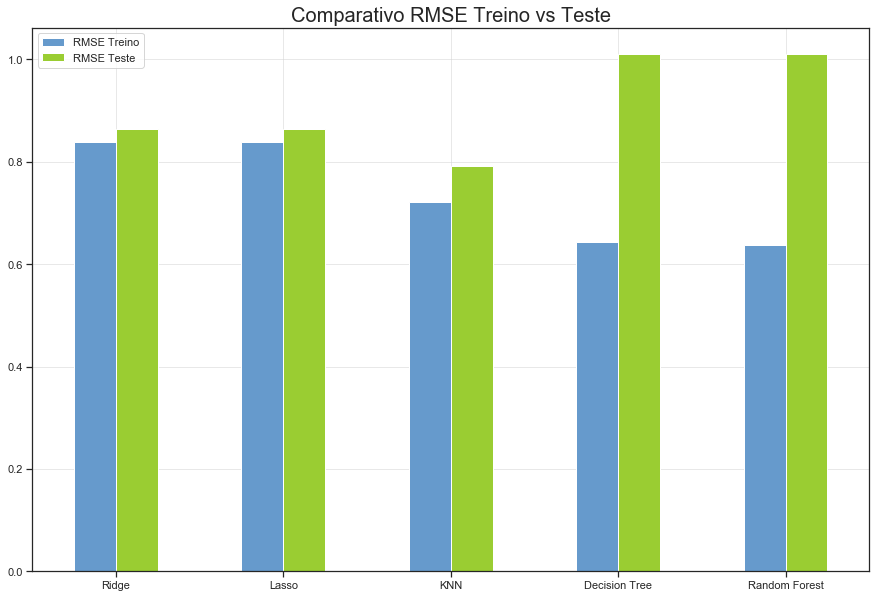

In [567]:
scores_plot(rmse_scores)

# Aplicando os melhores valores de parametros

In [813]:
taget_df = pd.read_csv('../data/cartola_2014/cartola_2014_test.csv')

In [814]:
taget_df[['PE','FC','FS','RB']].shape

(1610, 4)

In [815]:
taget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 33 columns):
atleta_id       1610 non-null int64
rodada          1610 non-null int64
clube_id        839 non-null float64
participou      1610 non-null int64
posicao_id      839 non-null float64
jogos_num       1610 non-null int64
pontos_num      1610 non-null float64
media_num       1610 non-null float64
preco_num       1610 non-null float64
variacao_num    1610 non-null float64
partida_id      1610 non-null float64
mando           1610 non-null int64
titular         839 non-null float64
substituido     1610 non-null int64
tempo_jogado    839 non-null float64
FS              1610 non-null int64
PE              1610 non-null int64
A               1610 non-null int64
FT              1610 non-null int64
FD              1610 non-null int64
FF              1610 non-null int64
G               1610 non-null int64
I               1610 non-null int64
PP              1610 non-null int64
RB             

In [816]:
better_corr = cartola[['PE','FC','FS','RB']]

X = cartola[['PE','FC','FS','RB']]
y = cartola['nota']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [817]:
norm = StandardScaler()
norm = norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [818]:
rmse_val = [] 
for K in range(15):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_norm, y_train)
    pred = model.predict(X_test_norm)
    error = np.sqrt(mean_squared_error( y_test, pred))
    rmse_val.append({'k':K, 'err':error})
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 1.4645186868083875
RMSE value for k=  2 is: 1.3305799956088629
RMSE value for k=  3 is: 1.2746951492281648
RMSE value for k=  4 is: 1.2603882521428824
RMSE value for k=  5 is: 1.2432448811990677
RMSE value for k=  6 is: 1.2215585720326103
RMSE value for k=  7 is: 1.2148129692836775
RMSE value for k=  8 is: 1.2120384907222352
RMSE value for k=  9 is: 1.286130651199363
RMSE value for k=  10 is: 1.2589331321950783
RMSE value for k=  11 is: 1.2437043434148747
RMSE value for k=  12 is: 1.2301335811016385
RMSE value for k=  13 is: 1.221023704347795
RMSE value for k=  14 is: 1.2131093600978309
RMSE value for k=  15 is: 1.2078040695925556


In [819]:
min_err = min(x['err'] for x in rmse_val)
better = next(item for item in rmse_val if item["err"] == min_err)
better

{'k': 15, 'err': 1.2078040695925556}

In [820]:
better['k']
model = KNeighborsRegressor(n_neighbors = better['k'])
model.fit(X_train_norm, y_train)
pred = model.predict(X_test_norm)
error = np.sqrt(mean_squared_error( y_test, pred))
print('RMSE value is:', error)

RMSE value is: 1.2078040695925556


In [821]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_inputed = imp.fit_transform(taget_df[['PE','FC','FS','RB']])

In [822]:
df_inputed.shape

(1610, 4)

In [837]:
pred_target = model.predict(df_inputed)
df_forest_test = pd.DataFrame({'ID': taget_df['atleta_id'], 'nota': pred_target.flatten()})

In [833]:
df_forest_test.head(100)

ID      nota
0   68910  5.300000
1   78123  5.300000
2   89295  5.300000
3   37738  5.500000
4   50490  6.033333
5   69214  5.300000
6   71639  5.966667
7   68995  5.800000
8   74140  5.300000
9   78932  5.633333
10  81260  5.733333
11  38348  5.533333
12  50338  5.833333
13  69305  5.666667
14  72108  5.300000
15  73955  5.733333
16  74097  5.300000
17  79060  5.300000
18  81158  5.900000
19  38625  5.400000
20  80374  5.300000
21  80950  6.300000
22  83171  5.300000
23  41364  5.300000
24  38146  5.300000
25  78641  5.300000
26  37658  6.100000
27  69032  5.466667
28  38407  6.133333
29  79376  6.300000
..    ...       ...
70  73396  5.300000
71  87250  5.966667
72  39174  5.300000
73  50390  5.866667
74  80226  5.266667
75  87267  5.300000
76  38544  5.900000
77  41401  5.300000
78  53509  6.500000
79  84350  5.633333
80  88970  5.900000
81  89408  6.166667
82  68810  5.900000
83  72136  6.066667
84  82539  5.300000
85  88112  5.633333
86  88936  5.300000
87  38468  5.700000
88  68921  5.300000
89  39609  5.300000
90  70148  5.866667
91  74096  5.300000
92  80575  5.733333
93  37664  5.500000
94  37711  6.266667
95  50385  6.000000
96  50454  5.833333
97  68748  5.300000
98  80407  5.866667
99  88036  5.300000

[100 rows x 2 columns]

In [827]:
df_forest_test.to_csv('antonio_esteves_submission.csv', index=False)

In [828]:
df_forest_test.shape

(1610, 2)